In [1]:
from __future__ import print_function, division
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import PolyCollection
from matplotlib.colors import colorConverter
%pylab notebook
import os
import sys
import numpy as np
import random
import copy
import traceback
import operator
from collections import defaultdict
from pprint import pprint
import string
from graph_tool.all import *
import scipy.stats as stats
from IPython.display import HTML
import pandas as pd
import sys
import os
lib_path = '/home/fgeigl/'
print('append', lib_path)
sys.path.append(lib_path)
import tools.mpl_tools as plt_tools
# import seaborn
matplotlib.rcParams.update({'font.size': 25})
matplotlib.rcParams['xtick.major.pad'] *= 2
matplotlib.rcParams['ytick.major.pad'] *= 2

Populating the interactive namespace from numpy and matplotlib
append /home/fgeigl/


/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
def find_files(base_dir, file_ending):
    res = list()
    for root, dirs, files in os.walk(base_dir):
        if not root.endswith('/'):
            root += '/'
        res.extend([root + i for i in filter(lambda x: x.endswith(file_ending), files)])
    return sorted(res)

base_dir = '/home/fgeigl/navigability_of_networks/output/bias_link_ins'
base_dir = '/home/fgeigl/navigability_of_networks/output/opt_link_man'
df_files = filter(lambda x: 'preprocessed' in x, find_files(base_dir,'.df'))
debug = False
plots_dir = base_dir + '/plots/'
if not os.path.isdir(plots_dir):
    os.makedirs(plots_dir)


data_sets = defaultdict(set)
for f in df_files:
    dset = f.rsplit('/',1)[-1].split('.gt',1)[0]
    data_sets[dset].add(f)

for key, val in data_sets.iteritems():
    print(key)
    for i in sorted(val):
        print('\t',i)

daserste
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0002_preprocessed.df
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0003_preprocessed.df
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0005_preprocessed.df
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0010_preprocessed.df
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0015_preprocessed.df
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0030_preprocessed.df
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0060_preprocessed.df
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0100_preprocessed.df
	 /home/fgeigl/navigability_of_networks/output/opt_link_man/daserste.gt/daserste.gt_bs0150_preprocessed.df
	 /home/fgeigl/navigability_

In [3]:
max_sample_size = 0.21
data_dict = dict()
for key, val in sorted(data_sets.iteritems(), key=operator.itemgetter(0), reverse=True)[:(1 if debug else len(data_sets))]:
    df_all = None
    print('read all dfs for', key, end=' ')
    sys.stdout.flush()
    for df_file in sorted(val):
        print('.', end='')
        bs = int(df_file.rsplit('_bs',1)[-1].split('_',1)[0])
        if bs > 200:
            continue
        df = pd.read_pickle(df_file)
        # print(sorted(df.columns))
        df = df[['sample-size', 'stat_dist_com_sum', 'orig_stat_dist_sum', 'add_top_block_links_fair']]        
        df['sample-size'] = np.round(df['sample-size'], 2)
        df = df[map(lambda x: x < max_sample_size ,df['sample-size'])]
        df['bias-strength'] = bs
        if df_all is None:
            df_all = df.copy()
        else:
            df_all = pd.concat([df_all, df])
    # print(df_all.head())
    data_dict[key] = df_all.copy()
    print('\nsample-sizes', sorted(set(df_all['sample-size'])))
    print('bias-strengths', sorted(set(df_all['bias-strength'])))

read all dfs for wiki4schools ..........
sample-sizes [0.01, 0.02, 0.050000000000000003, 0.080000000000000002, 0.10000000000000001, 0.12, 0.14999999999999999, 0.17999999999999999, 0.20000000000000001]
bias-strengths [2, 3, 5, 10, 15, 30, 60, 100, 150, 200]
read all dfs for tvthek_orf ..........
sample-sizes [0.01, 0.02, 0.050000000000000003, 0.080000000000000002, 0.10000000000000001, 0.12, 0.14999999999999999, 0.17999999999999999, 0.20000000000000001]
bias-strengths [2, 3, 5, 10, 15, 30, 60, 100, 150, 200]
read all dfs for daserste ..........
sample-sizes [0.01, 0.02, 0.050000000000000003, 0.080000000000000002, 0.10000000000000001, 0.12, 0.14999999999999999, 0.17999999999999999, 0.20000000000000001]
bias-strengths [2, 3, 5, 10, 15, 30, 60, 100, 150, 200]


<IPython.core.display.Javascript object>


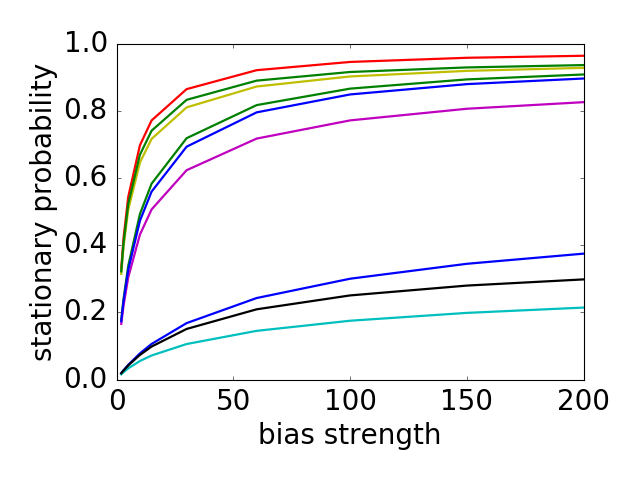

In [4]:
sample_sizes = [0.01, 0.1, 0.2]
fig, ax = plt.subplots()
for key, val in sorted(data_dict.iteritems(), key=operator.itemgetter(0), reverse=True):
    # fig, ax = plt.subplots()
    for key, df in val[map(lambda x: x in sample_sizes ,val['sample-size'])].groupby('sample-size'):
        filt_df = df[['bias-strength', 'stat_dist_com_sum']]
        grp_df = filt_df.groupby('bias-strength')
        grp_mean = grp_df.mean()
        grp_x = np.array(grp_mean.index)
        grp_mean = np.array(grp_mean).flatten()
        grp_std = np.array(grp_df.std()).flatten()
        #print(len(grp_x), len(grp_mean), len(grp_std))
        #print(grp_x)
        #print(grp_mean)
        #print(grp_std)
        ax.plot(grp_x, grp_mean, lw=2)
        # ax.fill_between(grp_x, grp_mean - grp_std, grp_mean + grp_std, alpha=0.2)
        # plt.show()
plt.xlabel('bias strength')
plt.ylabel('stationary probability')
plt.tight_layout()
plt.show()
plt.savefig(plots_dir + 'saturation.pdf')

Method: link_inseration


<IPython.core.display.Javascript object>


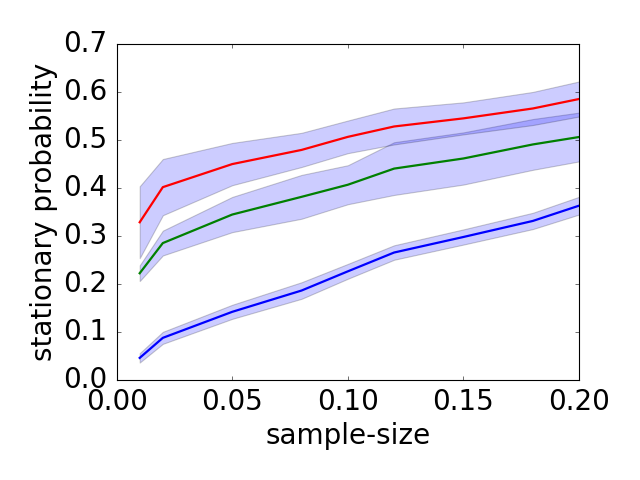

Method: bias


<IPython.core.display.Javascript object>


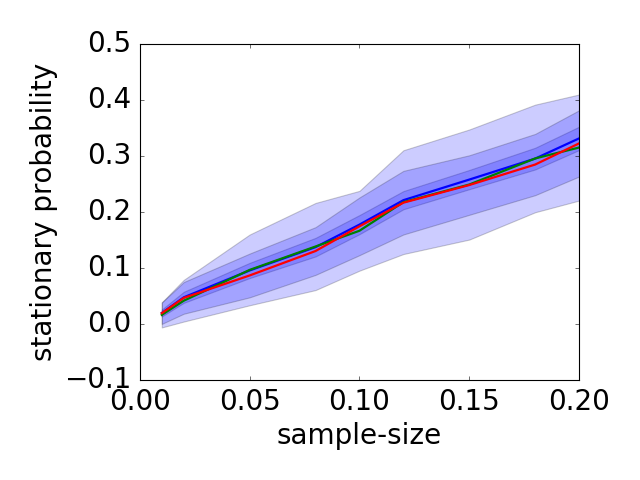

In [5]:
for method in ['link_inseration', 'bias']:
    print('Method:', method)
    measure = 'add_top_block_links_fair' if method == 'link_inseration' else 'stat_dist_com_sum'
    fig, ax = plt.subplots()
    bias_strength = 2
    for key, val in sorted(data_dict.iteritems(), key=operator.itemgetter(0), reverse=True):
        # fig, ax = plt.subplots()
        df = val[val['bias-strength'] == bias_strength].copy()
        df.drop('bias-strength', axis=1, inplace=True)
        # print(df.columns)
        df = df[['sample-size', measure]]
        grp_df = df.groupby('sample-size')
        grp_mean = grp_df.mean()
        grp_std = grp_df.std()
        grp_x = np.array(grp_mean.index)
        grp_mean = np.array(grp_mean).flatten()
        grp_std = np.array(grp_df.std()).flatten()
        # print(len(grp_x), len(grp_mean), len(grp_std))
        # print(grp_x)
        # print(grp_mean)
        # print(grp_std)
        ax.plot(grp_x, grp_mean, lw=2)
        ax.fill_between(grp_x, grp_mean - grp_std, grp_mean + grp_std, alpha=0.2)
            # plt.show()
    plt.xlabel('sample-size')
    plt.ylabel('stationary probability')
    plt.tight_layout()
    plt.show()
    plt.savefig(plots_dir + method + '_absolute.pdf')

Method: link_inseration


<IPython.core.display.Javascript object>


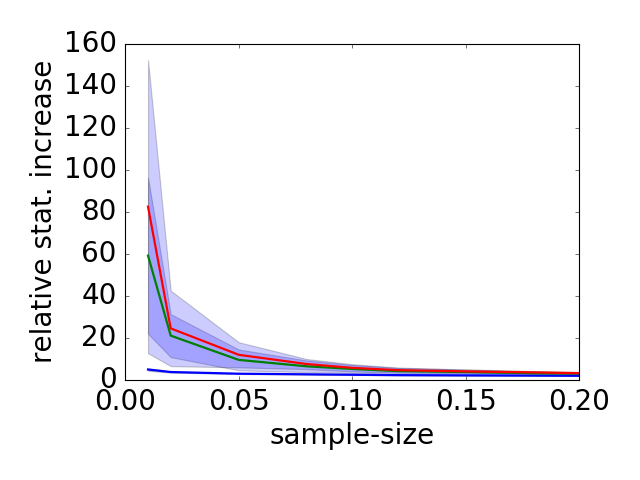

Method: bias


<IPython.core.display.Javascript object>


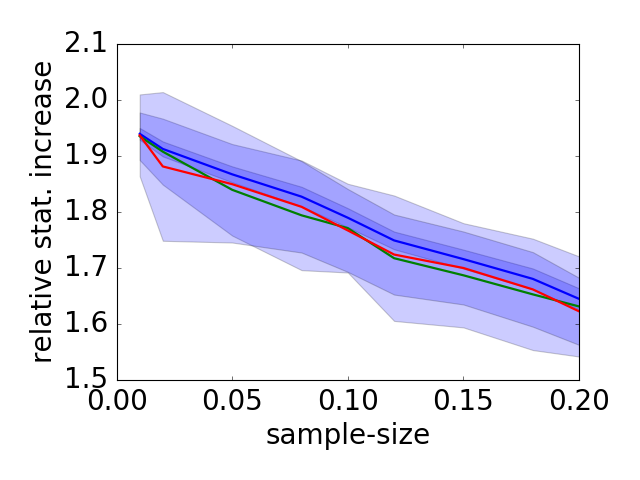

In [6]:
for method in ['link_inseration', 'bias']:
    print('Method:', method)
    measure = 'add_top_block_links_fair' if method == 'link_inseration' else 'stat_dist_com_sum'
    fig, ax = plt.subplots()
    bias_strength = 2
    for key, val in sorted(data_dict.iteritems(), key=operator.itemgetter(0), reverse=True):
        # fig, ax = plt.subplots()
        df = val[val['bias-strength'] == bias_strength].copy()
        df.drop('bias-strength', axis=1, inplace=True)
        # print(df.columns)
        df = df[['sample-size', measure, 'orig_stat_dist_sum']]
        df['relative_stat'] = df[measure] / df['orig_stat_dist_sum']
        df.drop([measure, 'orig_stat_dist_sum'], axis=1, inplace=True)
        grp_df = df.groupby('sample-size')
        grp_mean = grp_df.mean()
        grp_std = grp_df.std()
        grp_x = np.array(grp_mean.index)
        grp_mean = np.array(grp_mean).flatten()
        grp_std = np.array(grp_df.std()).flatten()
        # print(len(grp_x), len(grp_mean), len(grp_std))
        # print(grp_x)
        # print(grp_mean)
        # print(grp_std)
        ax.plot(grp_x, grp_mean, lw=2)
        ax.fill_between(grp_x, grp_mean - grp_std, grp_mean + grp_std, alpha=0.2, interpolate=True)
            # plt.show()
    plt.xlabel('sample-size')
    plt.ylabel('relative stat. increase')
    plt.tight_layout()
    plt.show()
    plt.savefig(plots_dir + method + '_relative.pdf')